In [9]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/MyDrive/Colab Notebooks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# map the data into the [0,1] range (convert to float!) and convert the labels to int32
def preprocess_images(images):
    return images.reshape(-1, 784).astype(np.float32) / 255

def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_labels = preprocess_labels(train_labels)
test_labels = preprocess_labels(test_labels)



[https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset](https://)
[https://stats.stackexchange.com/questions/245502/why-should-we-shuffle-data-while-training-a-neural-network/311318#311318](https://)

Repeat:
It will make dataset re-initialize after each iteration
producing indefinite sequence of elements.

Batch:
will take the first batch_size entries and make a batch out of them.

it helps the training converge fast,prevents any bias during the training,prevents the model from learning the order of the training


In [18]:
# Shuffle:
# Random buffer
#    |
#    |   Source dataset where all other elements live
#    |         |
#    ↓         ↓
# [1,2,3] <= [4,5,6]
train_data_1 = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(128).repeat() 
train_data_2 = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).repeat().batch(128) #best

train_data_3 = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(128).shuffle(60000).repeat()
train_data_4 = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(128).repeat().shuffle(60000) 

train_data_5 = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).repeat().shuffle(60000).batch(128)
train_data_6 = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).repeat().batch(128).shuffle(60000)

variables_train_data1 = [train_data_1, train_data_2, train_data_3, train_data_4, train_data_5, train_data_6]
# variables_train_data2 = []

# elems = 1
# for train_data in variables_train_data1:
#   for img_batch, lbl_batch in train_data:
#     print("shape: {} and size: {} of train_data_{}".format(train_data.shape, train_data.shape, elems))
#     elems +=1


test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(128)

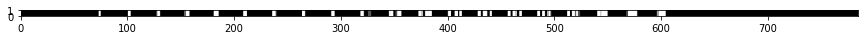

In [4]:
# here is an attempt at illustrating what flattening looks like
reshaped = train_images[155].reshape((1, 28*28))
plt.figure(figsize=(15, 0.1))
plt.pcolormesh(reshaped, cmap="Greys_r")
plt.show()

In [5]:
print(train_images.shape, train_labels.shape)

(60000, 784) (60000,)


In [12]:
Weight_0 = tf.Variable(tf.random.uniform(shape = [28*28, 256], minval = -0.1, maxval = 0.1, dtype = tf.dtypes.float32))
bias_0 = tf.Variable(np.zeros(256, dtype=np.float32))
Weight_2 = tf.Variable(tf.random.uniform(shape = [256, 10], minval = -0.1, maxval = 0.1, dtype = tf.dtypes.float32))
bias_2 = tf.Variable(np.zeros(10, dtype=np.float32))


def model(inputs):
    output_0 = tf.nn.relu(tf.matmul(inputs, Weight_0) + bias_0)
    output_2 = tf.nn.relu(tf.matmul(output_0, Weight_2) + bias_2)
    return output_2


train_steps = 2000
learning_rate = 0.5
from datetime import datetime
logdir = os.path.join("logs", "linear" + str(datetime.now()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
test_writer = tf.summary.create_file_writer(os.path.join(logdir, "test"))

TASK 1
-------------------------------

In [13]:
# training loop
# elems = 1

# for train_data in variables_train_data1:
for step, (image_batch, label_batch) in enumerate(train_data_2):
  if step > train_steps:
        break


  with tf.GradientTape(persistent=True) as tape:
      logits = model(image_batch)
      xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=label_batch))
      
  grads_0 = tape.gradient(xent, [Weight_0, bias_0])
  Weight_0.assign_sub(learning_rate * grads_0[0])
  bias_0.assign_sub(learning_rate * grads_0[1])

  grads_2 = tape.gradient(xent, [Weight_2, bias_2])
  Weight_2.assign_sub(learning_rate * grads_2[0])
  bias_2.assign_sub(learning_rate * grads_2[1])  

  del tape
  # every so often we print loss/accuracy
  if not step % 500:
      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch),
                            tf.float32))
      print("Step {}. Batch loss: {} Batch accuracy: {}".format(step+1, xent, acc))
test_preds = tf.argmax(model(test_images), axis=1,
                      output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels),
                            tf.float32))
with train_writer.as_default():
          tf.summary.scalar("accuracy", acc, step=step)
          tf.summary.image("input", tf.reshape(image_batch, [-1, 28, 28, 1]), step=step)
print("Test accuracy for train_data : {}".format(acc))
  # elems +=1

Step 1. Batch loss: 2.380023956298828 Batch accuracy: 0.0703125
Step 501. Batch loss: 0.35799264907836914 Batch accuracy: 0.875
Step 1001. Batch loss: 0.4522443413734436 Batch accuracy: 0.8125
Step 1501. Batch loss: 0.06598906219005585 Batch accuracy: 0.984375
Step 2001. Batch loss: 0.05237898975610733 Batch accuracy: 0.9765625
Test accuracy for train_data : 0.9754999876022339


TASK 2
-------------------------------------------------
repeat before shuffle leads to certain elements to be repeated before other elements appear even once

shuffle before repeat slows down the performance

batch before anything would create batches of the elements of the input dataset

the optimal choice is shuffle, repeat, batch gurantees that all sample are processed in one epoch and continous generation of data in different ordering.


TASK 3
------------------------------------------------
1.   Fail 1 

> Issue ->Loss was Nan , because too many neurons exploding gradient issue occurs

> Solution -> Reducing the number of neurons increased the accuracy to 94.3%

2.   Fail 2

> Issue ->Less accuracy because of sigmoid function

> Solution -> Changing the activation function to Relu increased the accuracy to 92.7%

3.   Fail 3

> Issue ->range of weight was [-0.4,0]

> Solution -> Changing the range [-0.4,0.4] , increases to 95.5%

4.   Fail 4

> Issue ->noise had a standard deviation of 4.0

> Solution -> Changing the standard deviation to 0.1 increased the accuracy to 95.8%. 

5.   Fail 5

> Issue ->Softmax activation function produces bad results

> Solution -> tanh increased the accuracy to 93.3%














